Importing Packages

In [99]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import numpy as np
from collections import defaultdict
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

# Load and Prepare Dataset

In [7]:
# Load TOX21 Dataset
data_path = 'tox21.csv'
df = pd.read_csv(data_path)

print(f"Initial dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")
print("First few rows of initial dataset:")
print(df.head(), "\n")

Initial dataset contains 7831 rows and 14 columns.

First few rows of initial dataset:
   NR-AR  NR-AR-LBD  NR-AhR  NR-Aromatase  NR-ER  NR-ER-LBD  NR-PPAR-gamma  \
0    0.0        0.0     1.0           NaN    NaN        0.0            0.0   
1    0.0        0.0     0.0           0.0    0.0        0.0            0.0   
2    NaN        NaN     NaN           NaN    NaN        NaN            NaN   
3    0.0        0.0     0.0           0.0    0.0        0.0            0.0   
4    0.0        0.0     0.0           0.0    0.0        0.0            0.0   

   SR-ARE  SR-ATAD5  SR-HSE  SR-MMP  SR-p53    mol_id  \
0     1.0       0.0     0.0     0.0     0.0   TOX3021   
1     NaN       0.0     NaN     0.0     0.0   TOX3020   
2     0.0       NaN     0.0     NaN     NaN   TOX3024   
3     NaN       0.0     NaN     0.0     0.0   TOX3027   
4     0.0       0.0     0.0     0.0     0.0  TOX20800   

                                              smiles  
0                       CCOc1ccc2nc(S(N)(=O)=O

7831
3079


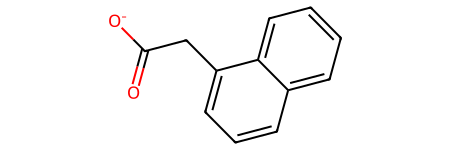

In [65]:
# remove duplicates
df = df.drop_duplicates(subset=['mol_id', 'smiles'])
print(df.shape[0])

# remove rows with NAN
df_cleaned = df.dropna(ignore_index=True)
print(df_cleaned.shape[0])

mol = Chem.MolFromSmiles(df_cleaned['smiles'][4])
mol
# make dataset with 'smiles' and toxi

In [9]:
df['smiles'][0]

'CCOc1ccc2nc(S(N)(=O)=O)sc2c1'

Turn into graph data using pytorch geometric

In [113]:
import torch
from torch_geometric.data import Data
import torch_geometric

# define encoding of bond type
BOND_TYPE = {
    "SINGLE": 0,
    "DOUBLE": 1,
    "TRIPLE": 2,
    "AROMATIC": 3
}

def graph_from_smiles(mol: Chem.rdchem.Mol, label: list[int]) -> Data:
    """Generate graph data from molecules and return as a torch_geometric object"""
    # atoms are edges and features for now are only the atomic number and degree
    node_features = []
    edge_features = []
    edge_indices = []
    # loop over atoms and add them as nodes
    for a in mol.GetAtoms():
        node_features.append([
            a.GetAtomicNum(),
            int(a.IsInRing()),
            1-int(a.IsInRing()),
            int(a.GetIsAromatic()),
            1-int(a.GetIsAromatic()),
            a.GetFormalCharge(),
            a.GetDegree()
        ])
    # bonds are edges with their connections defined as index pairs of edges and bond_type as features
    # loop over bonds and add their features and indices
    for b in mol.GetBonds():
        one_hot_type = [0] * 4
        idx = BOND_TYPE.get(str(b.GetBondType()).upper(), -1)
        if idx >= 0:
            one_hot_type[idx] = 1
        feats = one_hot_type + [
            int(b.GetIsAromatic()),
            1-int(b.GetIsAromatic()),
            int(b.GetIsConjugated()),
            1-int(b.GetIsConjugated()),
            int(b.IsInRing()),
            1-int(b.IsInRing())
        ]
        # append bond type twice because we have to add edge twice to make the graph undirectional
        edge_features.append(feats)
        edge_features.append(feats)
        edge_indices.append((b.GetBeginAtomIdx(), b.GetEndAtomIdx()))
        edge_indices.append((b.GetEndAtomIdx(), b.GetBeginAtomIdx()))

    # generate graph object and return it
    x = torch.tensor(node_features, dtype=torch.float)
    e = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    e_features = torch.tensor(edge_features, dtype=torch.float)
    y = torch.tensor(label, dtype=torch.long)
    return Data(x=x, edge_index=e, edge_attr=e_features, y=y)

def prepare_dataset(dat):
    """Generate a graph dataset from dataframe"""
    ds = []
    
    for i, row in tqdm(dat.iterrows(), total=len(dat)):
        mol = Chem.MolFromSmiles(row['smiles'])
        if mol is None:
            continue
        label = [row['NR-AR'],row['NR-AR-LBD'],row['NR-AhR'],row['NR-Aromatase'],row['NR-ER'], \
                 row['NR-ER-LBD'],row['NR-PPAR-gamma'],row['SR-ARE'],row['SR-ATAD5'],row['SR-HSE'], \
                 row['SR-MMP'],row['SR-p53']]
        ds.append(graph_from_smiles(mol, label))

    return ds

In [109]:
graph_data = prepare_dataset(df_cleaned)

  0%|          | 0/3079 [00:00<?, ?it/s]

[09:51:04] Explicit valence for atom # 4 Al, 6, is greater than permitted
[09:51:04] Explicit valence for atom # 4 Al, 6, is greater than permitted
[09:51:04] Explicit valence for atom # 9 Al, 6, is greater than permitted
[09:51:04] Explicit valence for atom # 5 Al, 6, is greater than permitted
[09:51:04] Explicit valence for atom # 16 Al, 6, is greater than permitted


In [110]:
len(graph_data)
graph_data[16].y

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

Visualize graph

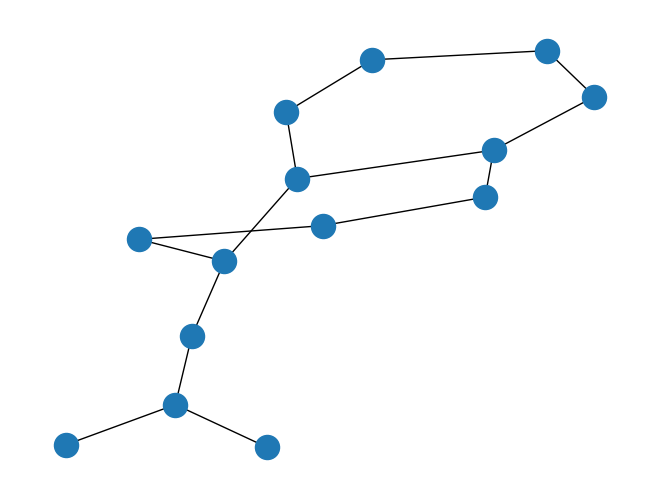

In [37]:
import networkx as nx

g = torch_geometric.utils.to_networkx(example_graph, to_undirected=True)
nx.draw(g)

# Define Neural Network and Train

Split into training, validation and test set

In [92]:
import torch, torch.nn.functional as F
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import (
    roc_auc_score, balanced_accuracy_score,
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

total_len = len(graph_data)
train_size = int(0.8 * total_len)
val_size = int(0.1 * total_len)
test_size = total_len - train_size - val_size

train_set, val_set, test_set = random_split(graph_data, [train_size, val_size, test_size])

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [149]:
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, dropout=0.0):
        super().__init__()
        self.conv1   = GCNConv(in_dim, hidden_dim)
        self.conv2   = GCNConv(hidden_dim, hidden_dim)
        self.dropout = dropout
        self.lin     = torch.nn.Linear(hidden_dim, out_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch)
        return self.lin(x)

class LossPlot():
    """Class for plotting training and validation loss."""

    def __init__(self):
        """Initialize the LossPlot class and set up the plot."""
        super(LossPlot, self).__init__()

        self.figLoss, self.axLoss  = plt.subplots()
        self.axLoss.set_yscale('log')

        # Display the plot dynamically in Jupyter
        self.hdisplay = display.display("", display_id = True)
        
        # Initialize empty plots for loss
        self.axLoss.plot([],[])
        self.axLoss.plot([],[])
        self.axLoss.set_xlabel('Epoch')
        self.axLoss.set_ylabel('Loss')
    
    def UpdatePlots(self, epoch, loss, validation):
        """Update the loss plots with new data.

        Parameters:
            epoch (int): Current epoch number.
            loss (float): Training loss.
            validation (float): Validation loss.
        """
        currentplot = self.axLoss.get_lines()
        currentplotLossx = currentplot[0].get_xdata()
        currentplotLossy = currentplot[0].get_ydata()
        currentplotVLossx = currentplot[1].get_xdata()
        currentplotVLossy = currentplot[1].get_ydata()

        # Remove old plots and add new data
        currentplot[1].remove()
        currentplot[0].remove()
        self.axLoss.plot(np.append(currentplotLossx,int(epoch)),
                        np.append(currentplotLossy, loss),'b-', label='Training Loss')

        self.axLoss.plot(np.append(currentplotVLossx,int(epoch)),
                        np.append(currentplotVLossy, validation),'r-', label='Validation Loss')

        self.axLoss.set_xlabel('Epoch')
        self.axLoss.set_ylabel('Loss')
        self.axLoss.legend()
        
        # Update the display
        self.hdisplay.update(self.figLoss)

def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out   = model(batch).flatten()
            preds.append(out.cpu())
            labels.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(labels)

In [87]:
train_set[0].y.size(0)

12

In [163]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}")

lr=1e-3

model = GCN(in_dim=train_set[0].x.size(1),hidden_dim=64,out_dim=train_set[0].y.size(0),dropout=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Training on device cpu


In [167]:
feat = next(iter(train_dataloader))

In [171]:
train_set[0].y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [169]:
feat.y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

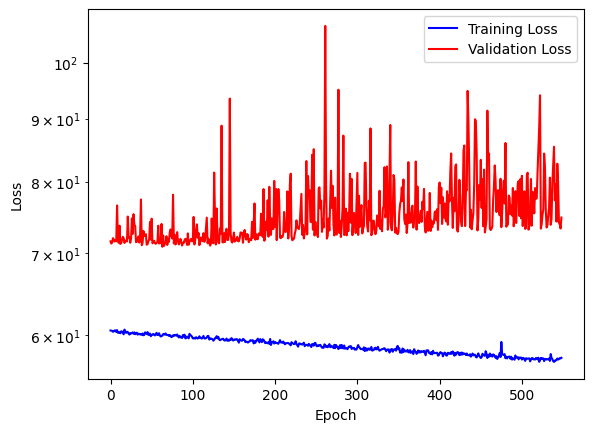

KeyboardInterrupt: 

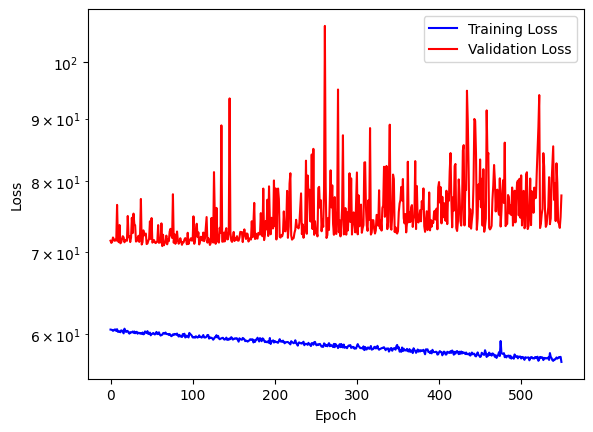

In [165]:
plot = LossPlot()

for epoch in range(1000):
    train_loss = 0.0
    model.train()
    for b in train_dataloader:
        b = b.to(device)
        optimizer.zero_grad()
        loss = F.cross_entropy(model(b).flatten(), b.y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    predsVal, labelsVal = evaluate(model, val_dataloader)
    vloss = F.cross_entropy(predsVal, labelsVal.float()).item()

    plot.UpdatePlots(epoch, train_loss/len(train_dataloader), vloss/len(val_dataloader))

In [116]:
32*12

384